# Test model

## Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import models
from utilities import ChestXrayHDF5

## Select dataset and best models

In [2]:
dataset = ChestXrayHDF5(f'/home/aisinai/work/HDF5_datasets/COVID19_binary_test_1024.hdf5')
model_scores = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/best_densenet_145.pt")
model_admits = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/best_densenet_129.pt")

## Compute predictions

In [3]:
scores = []
admits = []
intubs = []
deaths = []
preds_scores = []
preds_admits = []

for i, (img, score, admit, intub, death) in enumerate(dataset):
    sample_img = torch.rand((1,3,1024,1024))
    sample_img[0,:] = img
    sample_img = sample_img.cuda()
    scores.append(score.numpy())
    admits.append(admit.numpy())
    intubs.append(intub.numpy())
    deaths.append(death.numpy())
    preds_scores.append(model_scores(sample_img).detach().cpu().numpy()[0])
    preds_admits.append(model_admits(sample_img).detach().cpu().numpy()[0])
    if (i + 1) == len(dataset):
        break

## Compue AUROC and generate graph

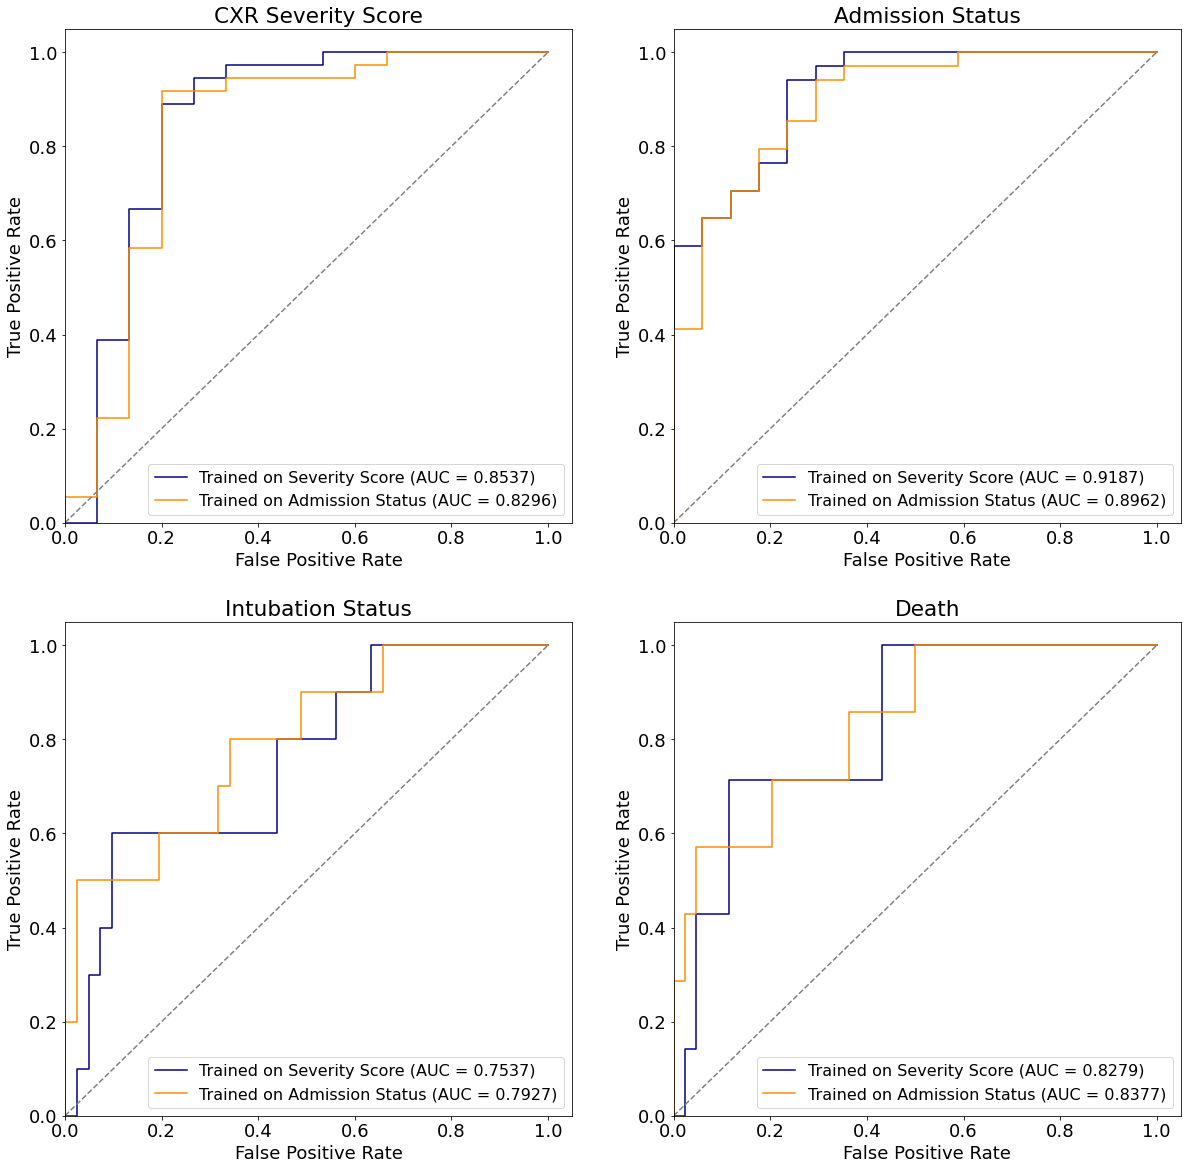

In [4]:
font = {'size': 18}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 20))

fontsize = 16
ymin = 0
ax1 = fig.add_subplot(221)

fpr_scores, tpr_scores, _ = roc_curve(scores, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, _ = roc_curve(scores, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax1.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity Score (AUC = {roc_auc_scores:.4f})')
ax1.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission Status (AUC = {roc_auc_admits:.4f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('CXR Severity Score')
ax1.legend(loc="lower right", fontsize = 16)

ax2 = fig.add_subplot(222)

fpr_scores, tpr_scores, _ = roc_curve(admits, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, _ = roc_curve(admits, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax2.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity Score (AUC = {roc_auc_scores:.4f})')
ax2.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission Status (AUC = {roc_auc_admits:.4f})')
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Admission Status')
ax2.legend(loc="lower right", fontsize = 16)

ax3 = fig.add_subplot(223)

fpr_scores, tpr_scores, _ = roc_curve(intubs, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, _ = roc_curve(intubs, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax3.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity Score (AUC = {roc_auc_scores:.4f})')
ax3.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission Status (AUC = {roc_auc_admits:.4f})')
ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Intubation Status')
ax3.legend(loc="lower right", fontsize = 16)

ax4 = fig.add_subplot(224)

fpr_scores, tpr_scores, _ = roc_curve(deaths, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
fpr_admits, tpr_admits, _ = roc_curve(deaths, preds_admits)
roc_auc_admits = auc(fpr_admits, tpr_admits)

ax4.plot(fpr_scores, tpr_scores, color='navy',
         label=f'Trained on Severity Score (AUC = {roc_auc_scores:.4f})')
ax4.plot(fpr_admits, tpr_admits, color='darkorange',
         label=f'Trained on Admission Status (AUC = {roc_auc_admits:.4f})')
ax4.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('Death')
ax4.legend(loc="lower right", fontsize = 16)
fig.show()


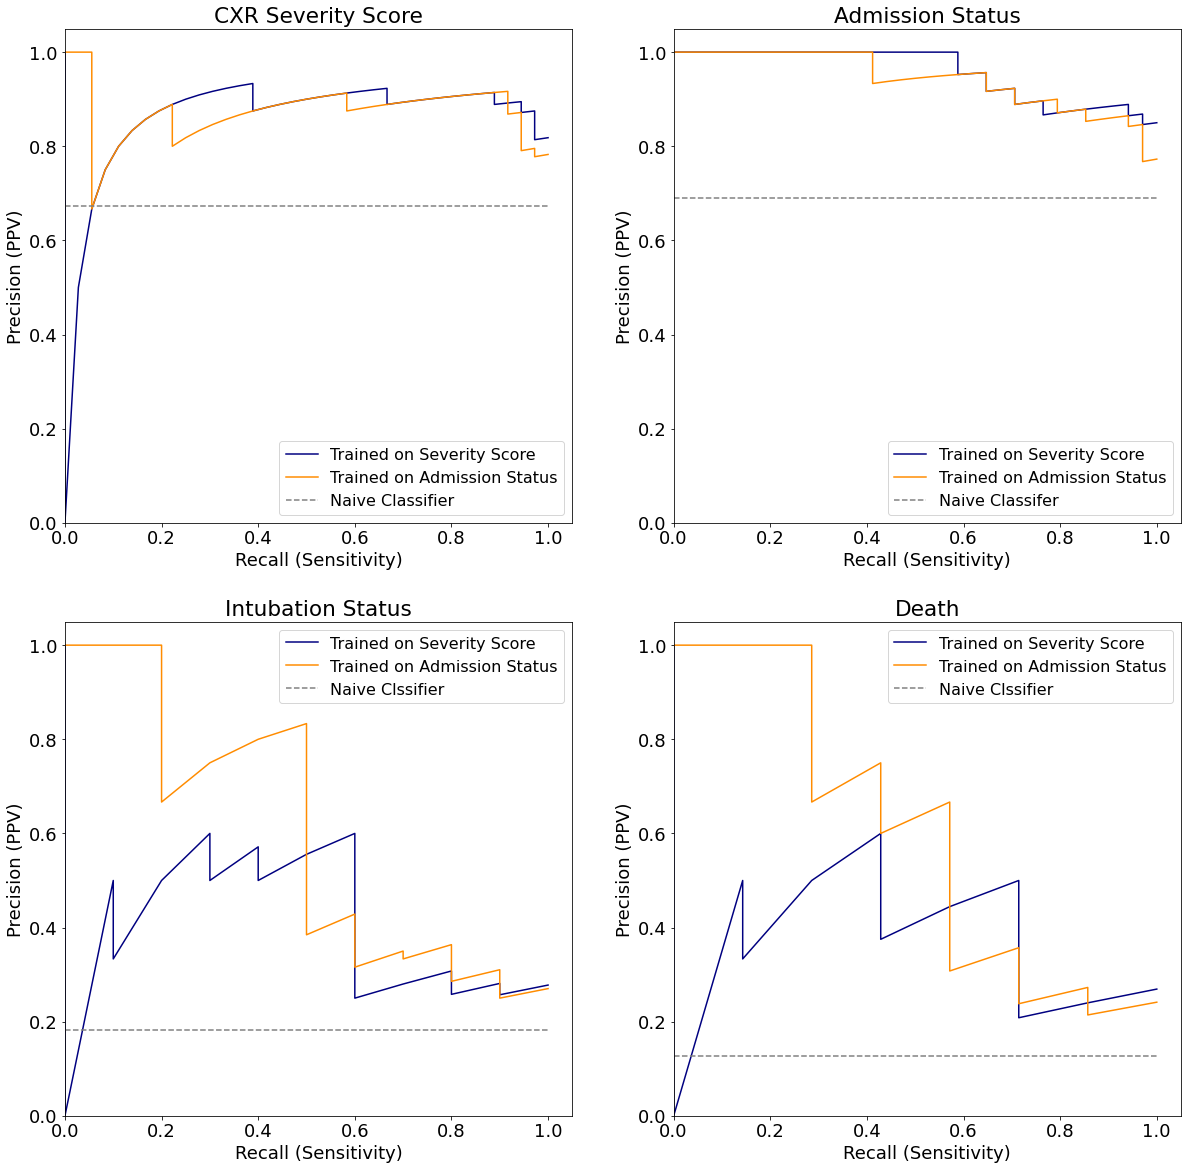

In [5]:
fig = plt.figure(figsize=(20, 20))

fontsize = 16
ymin = 0
ax1 = fig.add_subplot(221)

precision_scores, recall_scores, _ = precision_recall_curve(scores, preds_scores)
roc_auc_scores = auc(fpr_scores, tpr_scores)
precision_admits, recall_admits, _ = precision_recall_curve(scores, preds_admits)
roc_auc_admits = auc(fpr_scores, tpr_scores)

ax1.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax1.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax1.plot([0, 1], [37/55, 37/55], color='gray', linestyle='--',
         label='Naive Classifier')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision (PPV)')
ax1.set_title('CXR Severity Score')
ax1.legend(loc="lower right", fontsize=16)

ax2 = fig.add_subplot(222)

precision_scores, recall_scores, _ = precision_recall_curve(admits, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(admits, preds_admits)

ax2.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax2.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax2.plot([0, 1], [38/55, 38/55], color='gray', linestyle='--',
         label='Naive Classifer')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.set_title('Admission Status')
ax2.legend(loc="lower right", fontsize=16)

ax3 = fig.add_subplot(223)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits)

ax3.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax3.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax3.plot([0, 1], [10/55, 10/55], color='gray', linestyle='--',
         label='Naive Clssifier')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision (PPV)')
ax3.set_title('Intubation Status')
ax3.legend(loc="upper right", fontsize=16)

ax4 = fig.add_subplot(224)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits)

ax4.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax4.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax4.plot([0, 1], [7/55, 7/55], color='gray', linestyle='--',
         label='Naive Clssifier')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('Recall (Sensitivity)')
ax4.set_ylabel('Precision (PPV)')
ax4.set_title('Death')
ax4.legend(loc="upper right", fontsize=16)
fig.show()


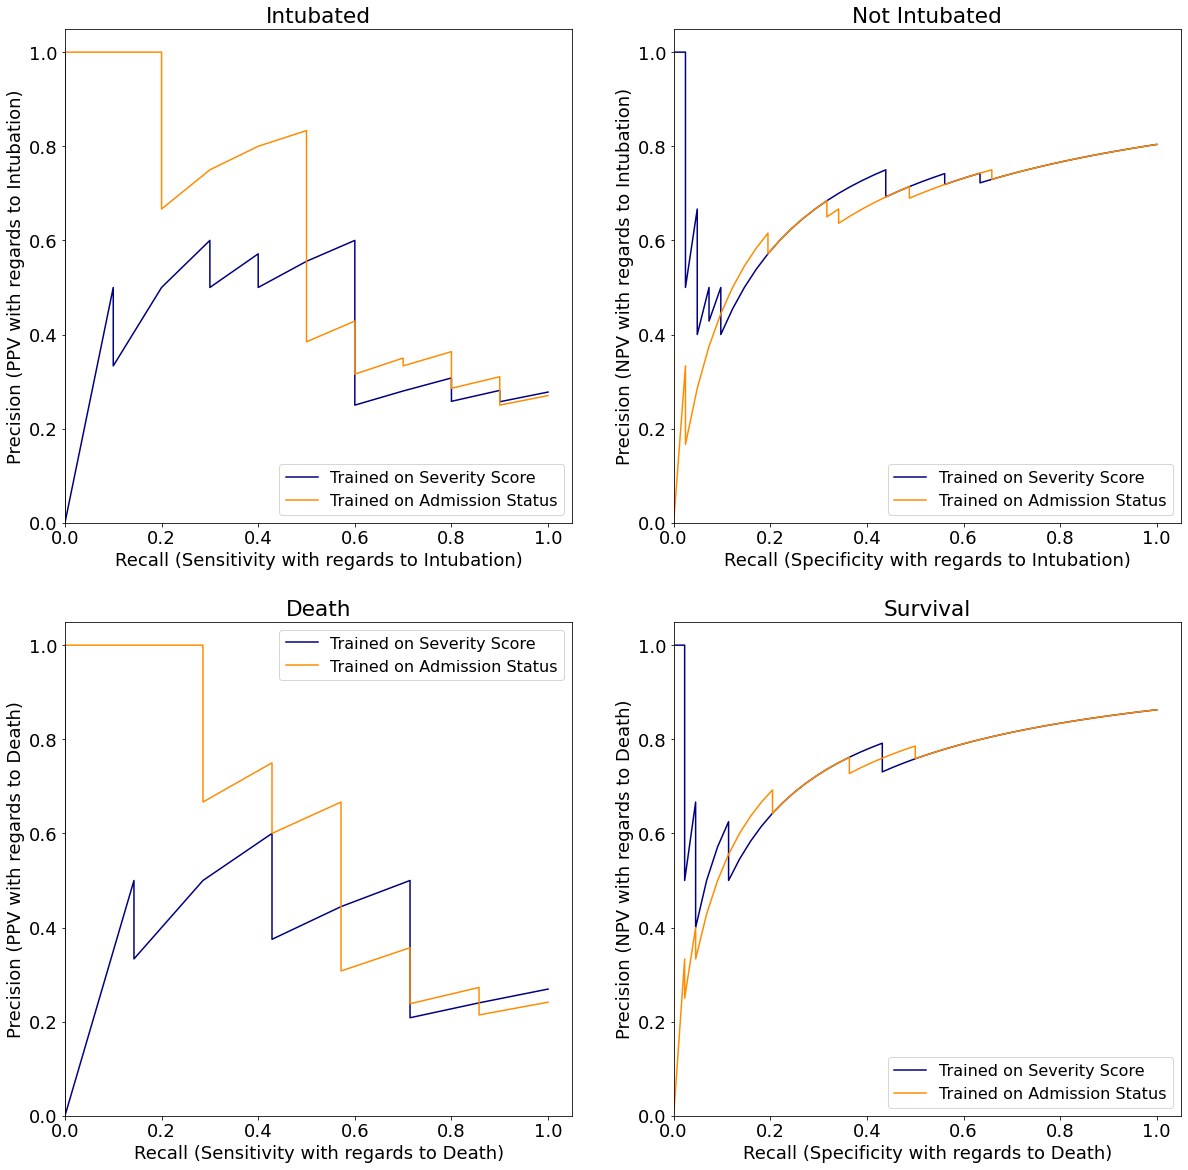

In [6]:
fig = plt.figure(figsize=(20, 20))

fontsize = 16
ymin = 0
ax1 = fig.add_subplot(221)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits)

ax1.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax1.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax1.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax1.set_xlabel('Recall (Sensitivity with regards to Intubation)')
ax1.set_ylabel('Precision (PPV with regards to Intubation)')
ax1.set_title('Intubated')
ax1.legend(loc="lower right", fontsize=16)
fig.show()

ax2 = fig.add_subplot(222)

precision_scores, recall_scores, _ = precision_recall_curve(intubs, preds_scores, pos_label=0)
precision_admits, recall_admits, _ = precision_recall_curve(intubs, preds_admits, pos_label=0)

ax2.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax2.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax2.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax2.set_xlabel('Recall (Specificity with regards to Intubation)')
ax2.set_ylabel('Precision (NPV with regards to Intubation)')
ax2.set_title('Not Intubated')
ax2.legend(loc="lower right", fontsize=16)

ax3 = fig.add_subplot(223)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits)

ax3.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax3.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax3.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax3.set_xlabel('Recall (Sensitivity with regards to Death)')
ax3.set_ylabel('Precision (PPV with regards to Death)')
ax3.set_title('Death')
ax3.legend(loc="upper right", fontsize=16)
fig.show()

ax4 = fig.add_subplot(224)

precision_scores, recall_scores, _ = precision_recall_curve(deaths, preds_scores, pos_label=0)
precision_admits, recall_admits, _ = precision_recall_curve(deaths, preds_admits, pos_label=0)

ax4.plot(recall_scores, precision_scores, color='navy',
         label=f'Trained on Severity Score')
ax4.plot(recall_admits, precision_admits, color='darkorange',
         label=f'Trained on Admission Status')
ax4.axis(xmin=0, xmax=1.05, ymin=0, ymax=1.05)
ax4.set_xlabel('Recall (Specificity with regards to Death)')
ax4.set_ylabel('Precision (NPV with regards to Death)')
ax4.set_title('Survival')
ax4.legend(loc="lower right", fontsize=16)
fig.show()

fig.show()


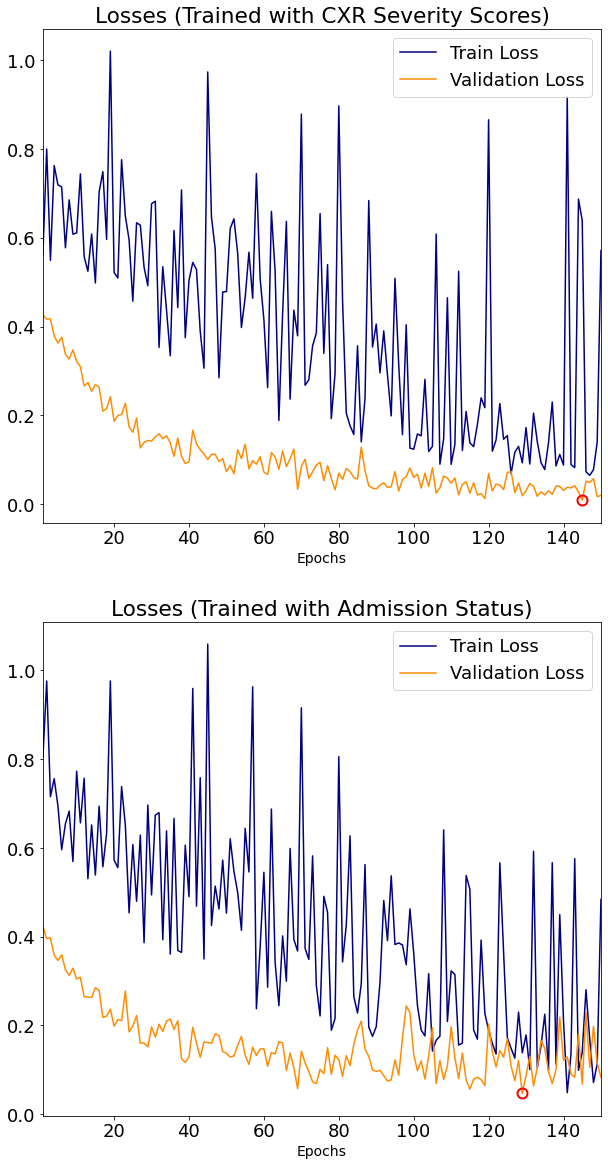

In [7]:
epochs = range(1, 150 + 1)
losses_scores = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/losses.pt")
losses_scores = losses_scores[:,0:150]
losses_admits = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/losses.pt")
losses_admits = losses_admits[:,0:150]


fig = plt.figure(figsize=(10, 20))
latest_epoch = 150

fontsize = 14
ax1 = fig.add_subplot(211)
ax1.plot(epochs, losses_scores[0, :], '-', color='navy')
ax1.plot(epochs, losses_scores[1, :], '-', color='darkorange')
ax1.plot(145, losses_scores[1, 144], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax1.set_title('Losses (Trained with CXR Severity Scores)')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=1, xmax=latest_epoch)
ax1.legend(["Train Loss", "Validation Loss"], loc="upper right")

ax2 = fig.add_subplot(212)
ax2.plot(epochs, losses_admits[0, :], '-', color='navy')
ax2.plot(epochs, losses_admits[1, :], '-', color='darkorange')
ax2.plot(129, losses_admits[1, 128], 'o', color='red', markerfacecolor='None', markersize=10, markeredgewidth=2)
ax2.set_title('Losses (Trained with Admission Status)')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=1, xmax=latest_epoch)
ax2.legend(["Train Loss", "Validation Loss"], loc="upper right")

fig.show()

<Figure size 1440x1440 with 0 Axes>

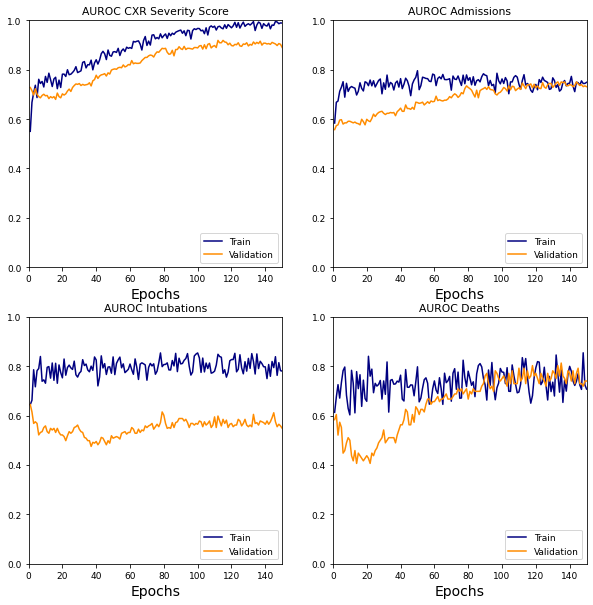

In [8]:
font = {'size': 9}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 20))

epochs = range(1, 150 + 1)
aurocs = torch.load("/home/aisinai/work/covid19/densenet121/20200507/score3/aurocs.pt")
aurocs = aurocs[:,0:150]

fig = plt.figure(figsize=(10, 10))
latest_epoch = 150

ymin = 0
ax1 = fig.add_subplot(221)
ax1.plot(epochs, aurocs[0, :, 0], '-', color='navy')
ax1.plot(epochs, aurocs[1, :, 0], '-', color='darkorange')
ax1.legend(["Train", "Validation"], loc="lower right")
ax1.set_title('AUROC CXR Severity Score')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax2 = fig.add_subplot(222)
ax2.plot(epochs, aurocs[0, :, 1], '-', color='navy')
ax2.plot(epochs, aurocs[1, :, 1], '-', color='darkorange')
ax2.legend(["Train", "Validation"], loc="lower right")
ax2.set_title('AUROC Admissions')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax3 = fig.add_subplot(223)
ax3.plot(epochs, aurocs[0, :, 2], '-', color='navy')
ax3.plot(epochs, aurocs[1, :, 2], '-', color='darkorange')
ax3.legend(["Train", "Validation"], loc="lower right")
ax3.set_title('AUROC Intubations')
ax3.set_xlabel('Epochs', fontsize=fontsize)
ax3.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax4 = fig.add_subplot(224)
ax4.plot(epochs, aurocs[0, :, 3], '-', color='navy')
ax4.plot(epochs, aurocs[1, :, 3], '-', color='darkorange')
ax4.legend(["Train", "Validation"], loc="lower right")
ax4.set_title('AUROC Deaths')
ax4.set_xlabel('Epochs', fontsize=fontsize)
ax4.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

plt.show()

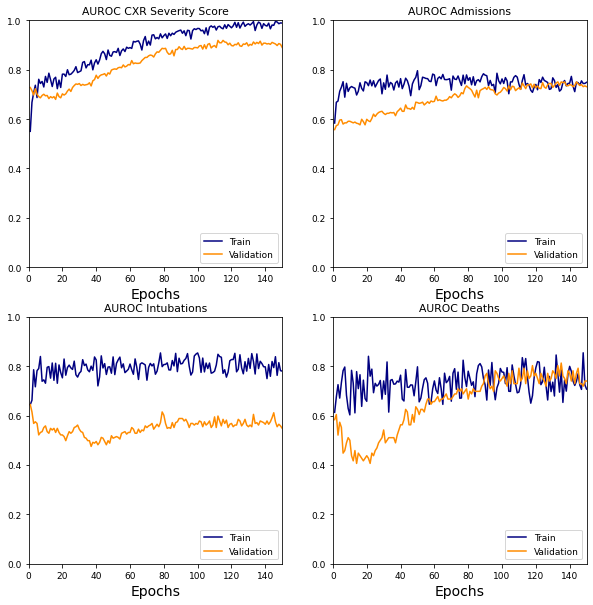

In [9]:
epochs = range(1, 150 + 1)
losses = torch.load("/home/aisinai/work/covid19/densenet121/20200507/admit3/losses.pt")
aurocs = aurocs[:,0:150]

fig = plt.figure(figsize=(10, 10))
latest_epoch = 150

ax1 = fig.add_subplot(221)
ax1.plot(epochs, aurocs[0, :, 0], '-', color='navy')
ax1.plot(epochs, aurocs[1, :, 0], '-', color='darkorange')
ax1.legend(["Train", "Validation"], loc="lower right")
ax1.set_title('AUROC CXR Severity Score')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax2 = fig.add_subplot(222)
ax2.plot(epochs, aurocs[0, :, 1], '-', color='navy')
ax2.plot(epochs, aurocs[1, :, 1], '-', color='darkorange')
ax2.legend(["Train", "Validation"], loc="lower right")
ax2.set_title('AUROC Admissions')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax3 = fig.add_subplot(223)
ax3.plot(epochs, aurocs[0, :, 2], '-', color='navy')
ax3.plot(epochs, aurocs[1, :, 2], '-', color='darkorange')
ax3.legend(["Train", "Validation"], loc="lower right")
ax3.set_title('AUROC Intubations')
ax3.set_xlabel('Epochs', fontsize=fontsize)
ax3.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

ax4 = fig.add_subplot(224)
ax4.plot(epochs, aurocs[0, :, 3], '-', color='navy')
ax4.plot(epochs, aurocs[1, :, 3], '-', color='darkorange')
ax4.legend(["Train", "Validation"], loc="lower right")
ax4.set_title('AUROC Deaths')
ax4.set_xlabel('Epochs', fontsize=fontsize)
ax4.axis(xmin=0, xmax=latest_epoch, ymin=ymin, ymax=1)

plt.show()